In [1]:
from ase.build import bulk
import io
from ase.visualize import view
from ase.io import read, write
import numpy as np
import os
import fileinput
from shutil import rmtree
from shutil import copyfile
from ase.phonons import Phonons
import matplotlib.pyplot as plt
from ase.build import make_supercell
from ase.optimize import LBFGS
from acease.ace_calculator import ACEpotentials, initialize_julia, set_params
from ase.constraints import UnitCellFilter
from ase.units import J
from ase.constraints import FixCartesian
import pandas as pd

In [ ]:
model_path = "model.json"
python_path = "venv/bin/python"
m1 = 'five_models_no_defects/coeffs_subset_1.csv'
m2 = 'five_models_no_defects/coeffs_subset_2.csv'
m3 = 'five_models_no_defects/coeffs_subset_3.csv'
m4 = 'five_models_no_defects/coeffs_subset_4.csv'
m5 = 'five_models_no_defects/coeffs_subset_5.csv'
g1 = 'five_models_stacking_faults/coeffs_subset_1.csv'
g2 = 'five_models_stacking_faults/coeffs_subset_2.csv'
g3 = 'five_models_stacking_faults/coeffs_subset_3.csv'
g4 = 'five_models_stacking_faults/coeffs_subset_4.csv'
g5 = 'five_models_stacking_faults/coeffs_subset_5.csv'

initialize_julia(python_path)  # pass your python path

In [3]:
calculator = ACEpotentials(model_path) #This is specifically and ace calc

In [ ]:
struct = bulk('Ti', 'hcp', a=2.7,c=4.6)
struct.calc = calculator
print(struct.get_potential_energy())
#if there is an output, mean model is working!!!

-3187.207689556833


In [ ]:
''' Hello, this is for stacking faults: the set up has been complete and the following is going to be done:

    We are going to analyse a few different stacking faults: Namely: Basal, Pris 1, Pris 2, Pyrm 1, Pyrm 2

    1. Create Gamma surface for each trained on basal stacking:
    2. sample 10 points using LHC sampling, and perturb the system each sample found
    3. Run DFT on these configs
    4. Use those to make better ACE model
    5. Look at the difference between just using the Connors data base and the stacking fault informed one
'''

In [5]:
# This function allows us to change the calculator, as a computation is required with a "new" structure. Issue that needs to be resolved with ACE in Python

def change_calc(struct,calculator,parameters):
    struct_copy = struct.copy()
    struct = bulk('Ti', 'hcp', a=2.7,c=10)
    calculator = set_params(calculator, parameters)
    struct.calc = calculator
    struct.get_potential_energy()
    struct = struct_copy.copy()
    return calculator



In [37]:
#Now we look at the gamma line that we can compare with the paper on the stacking faults

def create_gamma_line(bulk,slip_direction,file_name,calculator,pointer):
    # does what the name of the function is


    plt.figure(figsize=(6, 6))
    number_of_points = 11
    x = np.linspace(0, 0.6, number_of_points)
    original_cell = bulk.cell.copy()
    original_cell = bulk.cell.copy()
    energies = []
    images = []
    all_energies = []
    all_energies_gamma = []
    for j in range(5):
        energies = []
        images = []
        if j == 0:
            file_path = m1
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 1:
            file_path = m2
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 2:
            file_path = m3
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 3:
            file_path = m4
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 4:
            file_path = m5
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        for i in range(number_of_points):
            shift = (slip_direction * (1/(number_of_points-1))*i)*0.6
            
            bulk_copy = bulk.copy()
            bulk_copy.set_cell(original_cell)
            bulk_copy.set_cell([bulk_copy.cell[0],bulk_copy.cell[1],bulk_copy.cell[2]+shift])
            bulk_copy.wrap()
            bulk_copy.calc = calculator

            constraints = [FixCartesian(con, [True, True, False]) for con in range(len(bulk_copy))]
            bulk_copy.set_constraint(constraints)
            mask = [[False, False, False],
                [False, False, False],
                [False, False, True]]
            ucf = UnitCellFilter(bulk_copy, mask= mask)

            dyn = LBFGS(ucf)
            #set tol to 0.0001
            dyn.run(fmax=0.0001)
            # write(output_file, bulk_copy, append=True)
            
            #comment if not needing the castep cell files

            e = bulk_copy.get_potential_energy()
            if(i == 0):
                bulk_energy = e
            surface_size = np.linalg.norm(np.cross(bulk_copy.cell[0],bulk_copy.cell[1]))
            energies.append((e-bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size))
            images.append(bulk_copy)
            # cell_file = os.path.join(output_dir, f"{count}.cell")
            bulk_copy.calc = None
            all_energies.append(energies)
    


    for j in range(5):
        energies = []
        images = []
        if j == 0:
            file_path = g1
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 1:
            file_path = g2
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 2:
            file_path = g3
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 3:
            file_path = g4
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        elif j == 4:
            file_path = g5
            df = pd.read_csv(file_path,header = None)
            parameters = np.array(df)
            params = parameters.ravel()
            calculator = change_calc(bulk,calculator,params)
        for i in range(number_of_points):
            shift = (slip_direction * (1/(number_of_points-1))*i)*0.6
            
            bulk_copy = bulk.copy()
            bulk_copy.set_cell(original_cell)
            bulk_copy.set_cell([bulk_copy.cell[0],bulk_copy.cell[1],bulk_copy.cell[2]+shift])
            bulk_copy.wrap()
            bulk_copy.calc = calculator

            constraints = [FixCartesian(con, [True, True, False]) for con in range(len(bulk_copy))]
            bulk_copy.set_constraint(constraints)
            mask = [[False, False, False],
                [False, False, False],
                [False, False, True]]
            ucf = UnitCellFilter(bulk_copy, mask= mask)

            dyn = LBFGS(ucf)
            dyn.run(fmax=0.0001)
            # write(output_file, bulk_copy, append=True)
            
            #comment if not needing the castep cell files

            e = bulk_copy.get_potential_energy()
            if(i == 0):
                bulk_energy = e
            surface_size = np.linalg.norm(np.cross(bulk_copy.cell[0],bulk_copy.cell[1]))
            energies.append((e-bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size))
            images.append(bulk_copy)
            # cell_file = os.path.join(output_dir, f"{count}.cell")
            bulk_copy.calc = None
            all_energies_gamma.append(energies)



    all_energies = np.array(all_energies) 
    mean_energies_n = np.mean(all_energies, axis=0)
    std_energies_n = np.std(all_energies, axis=0)
    plt.plot(x, mean_energies_n, label="no_defects Mean", color="blue")
    plt.fill_between(x,
                     mean_energies_n - std_energies_n,
                     mean_energies_n + std_energies_n,
                     alpha=0.3, color="blue", label="±1 std (no_defects)")
    
    all_energies_gamma = np.array(all_energies_gamma) 
    mean_energies_g = np.mean(all_energies_gamma, axis=0)
    std_energies_g = np.std(all_energies_gamma, axis=0)
    plt.plot(x, mean_energies_g, label="gamma_informed Mean", color="red")
    plt.fill_between(x,
                     mean_energies_g - std_energies_g,
                     mean_energies_g + std_energies_g,
                     alpha=0.3, color="red", label="±1 std (gamma_informed)")


    df = pd.read_csv("data_points_gamma_lines.csv", header=None, names=["x", "y"])

    # Extract only the y values (second column)
    y_values = df["y"].tolist()

    # Break into 4 groups of 11 consecutive points
    groups = [y_values[i:i+11] for i in range(0, 44, 11)]
    plt.plot(x,groups[pointer], '-o',label = "Literature (Vasp Relaxed)",color = "green")
    

    #Now we extra DFT along the gamma line that we have!
    images = read("my_and_connor.xyz", index=":")
    qm_energies = [atoms.info.get("QM_energy") for atoms in images]
    qm_energies_plot = []
    qm_energies_plot.append(0)
    for e in qm_energies[6970+pointer*10:6980+pointer*10]:
        qm_energies_plot.append((e-bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size))
    plt.plot(x, qm_energies_plot, '-o', label="DFT (Relaxed with ACE)",color = "orange")

    # don't have a basal point as we are happy that it is well converged
    prism1_point = (-63753.39751906- bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size)
    pyrm1_point  = (-82879.43240445- bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size)
    pyrm2_point =  (-89254.25363093- bulk_energy)*(1000)/(J*((1e-10)**2)*surface_size)    # These are not required for the px915
    if pointer == 1:
        plt.scatter(x[8], prism1_point, color="black", marker="D", 
                label="Relaxed Reference Point", zorder=10)
    elif pointer == 2:
        plt.scatter(x[8], pyrm1_point, color="black", marker="D", 
                    label="Relaxed Reference Point", zorder=10)
    elif pointer == 3:
        plt.scatter(x[7], pyrm2_point, color="black", marker="D", 
                    label="Relaxed Reference Point", zorder=10)



    plt.tight_layout()
    plt.ylabel(r'mJ/m$^2$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, ls="--", alpha=0.6)
    if pointer == 0 or pointer == 1:
        plt.legend(fontsize = 15)
    plt.savefig("gamma_line_GPFE.png", bbox_inches='tight')
    plt.show()

    # We return the energy arrays so that we can look at what the stable stacking fault is for the models
    return mean_energies_g,std_energies_g,mean_energies_n,std_energies_n,qm_energies_plot,groups[pointer]
    
    # The lattice constants of the structure that we are using are a = 2.939, b = 4.647

       Step     Time          Energy          fmax
LBFGS:    0 12:16:55   -63753.581720        0.006060


/tmp/ipykernel_1640/1558579954.py:63: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:16:55   -63753.548981        0.059783
       Step     Time          Energy          fmax
LBFGS:    0 12:16:55   -63753.480150        0.181381
       Step     Time          Energy          fmax
LBFGS:    0 12:16:55   -63753.439092        0.233488
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.457594        0.167880
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.489322        0.093151
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.490845        0.093446
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.436541        0.185596
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.330661        0.458328
       Step     Time          Energy          fmax
LBFGS:    0 12:16:56   -63753.198861        0.814859
       Step     Time          Energy          fmax
LBFGS:    0 1

/tmp/ipykernel_1640/1558579954.py:63: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.548701        0.067624
       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.482962        0.190674
       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.446044        0.235978
       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.465924        0.158883
       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.502119        0.050480
       Step     Time          Energy          fmax
LBFGS:    0 12:16:57   -63753.503980        0.050118
       Step     Time          Energy          fmax
LBFGS:    0 12:16:58   -63753.443694        0.200460
       Step     Time          Energy          fmax
LBFGS:    0 12:16:58   -63753.333583        0.484244
       Step     Time          Energy          fmax
LBFGS:    0 12:16:58   -63753.203011        0.832852
       Step     Time          Energy          fmax
LBFGS:    0 1

/tmp/ipykernel_1640/1558579954.py:63: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:16:58   -63753.547701        0.058827
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.485880        0.155641
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.453730        0.178626
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.468168        0.123804
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.500048        0.039993
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.501678        0.039862
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.443211        0.173835
       Step     Time          Energy          fmax
LBFGS:    0 12:16:59   -63753.334678        0.472446
       Step     Time          Energy          fmax
LBFGS:    0 12:17:00   -63753.205541        0.844876
       Step     Time          Energy          fmax
LBFGS:    0 1

/tmp/ipykernel_1640/1558579954.py:63: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:00   -63753.549899        0.062790
       Step     Time          Energy          fmax
LBFGS:    0 12:17:00   -63753.480106        0.170294
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.437682        0.205616
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.446011        0.156798
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.471216        0.058387
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.472396        0.057036
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.422153        0.191100
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.320804        0.479584
       Step     Time          Energy          fmax
LBFGS:    0 12:17:01   -63753.190012        0.841285
       Step     Time          Energy          fmax
LBFGS:    0 1

/tmp/ipykernel_1640/1558579954.py:63: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:02   -63753.549748        0.056594
       Step     Time          Energy          fmax
LBFGS:    0 12:17:02   -63753.482825        0.155003
       Step     Time          Energy          fmax
LBFGS:    0 12:17:02   -63753.448158        0.189898
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.469460        0.148438
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.507159        0.113564
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.509203        0.113821
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.447119        0.177282
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.331911        0.471639
       Step     Time          Energy          fmax
LBFGS:    0 12:17:03   -63753.193487        0.831545
       Step     Time          Energy          fmax
LBFGS:    0 1

/tmp/ipykernel_1640/1558579954.py:131: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:04   -63753.561693        0.064834
       Step     Time          Energy          fmax
LBFGS:    0 12:17:04   -63753.483800        0.176579
       Step     Time          Energy          fmax
LBFGS:    0 12:17:04   -63753.424905        0.227102
       Step     Time          Energy          fmax
LBFGS:    0 12:17:04   -63753.420811        0.161151
       Step     Time          Energy          fmax
LBFGS:    0 12:17:04   -63753.440776        0.037952
       Step     Time          Energy          fmax
LBFGS:    0 12:17:05   -63753.441828        0.038551
       Step     Time          Energy          fmax
LBFGS:    0 12:17:05   -63753.400815        0.214361
       Step     Time          Energy          fmax
LBFGS:    0 12:17:05   -63753.325004        0.571000
       Step     Time          Energy          fmax
LBFGS:    0 12:17:05   -63753.227264        1.016596
LBFGS:    1 12:17:05   -63753.256279        0.876727
       Step

/tmp/ipykernel_1640/1558579954.py:131: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.555601        0.069101
       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.478297        0.181938
       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.419690        0.228284
       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.416531        0.159673
       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.440298        0.030841
       Step     Time          Energy          fmax
LBFGS:    0 12:17:06   -63753.441656        0.025908
       Step     Time          Energy          fmax
LBFGS:    0 12:17:07   -63753.397133        0.236535
       Step     Time          Energy          fmax
LBFGS:    0 12:17:07   -63753.320021        0.596445
       Step     Time          Energy          fmax
LBFGS:    0 12:17:07   -63753.226423        1.027033
LBFGS:    1 12:17:07   -63753.256172        0.886667
       Step

/tmp/ipykernel_1640/1558579954.py:131: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.557589        0.066656
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.482160        0.161592
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.427690        0.188707
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.421253        0.140499
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.441293        0.026945
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.442411        0.021825
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08   -63753.400112        0.221094
       Step     Time          Energy          fmax
LBFGS:    0 12:17:09   -63753.322080        0.586904
       Step     Time          Energy          fmax
LBFGS:    0 12:17:09   -63753.225592        1.018140
LBFGS:    1 12:17:09   -63753.255010        0.883810
       Step

/tmp/ipykernel_1640/1558579954.py:131: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.559290        0.067753
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.482400        0.168497
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.425932        0.206263
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.419179        0.155387
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.439174        0.029296
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.440360        0.025720
       Step     Time          Energy          fmax
LBFGS:    0 12:17:10   -63753.399538        0.216824
       Step     Time          Energy          fmax
LBFGS:    0 12:17:11   -63753.324602        0.579248
       Step     Time          Energy          fmax
LBFGS:    0 12:17:11   -63753.228779        1.010211
LBFGS:    1 12:17:11   -63753.257699        0.877119
       Step

/tmp/ipykernel_1640/1558579954.py:131: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(bulk_copy, mask= mask)


       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.562531        0.065916
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.484436        0.170919
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.427062        0.209282
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.421994        0.148795
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.443047        0.046544
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.444257        0.047145
       Step     Time          Energy          fmax
LBFGS:    0 12:17:12   -63753.401900        0.205993
       Step     Time          Energy          fmax
LBFGS:    0 12:17:13   -63753.324757        0.579492
       Step     Time          Energy          fmax
LBFGS:    0 12:17:13   -63753.228783        1.016859
LBFGS:    1 12:17:13   -63753.257781        0.881324
       Step

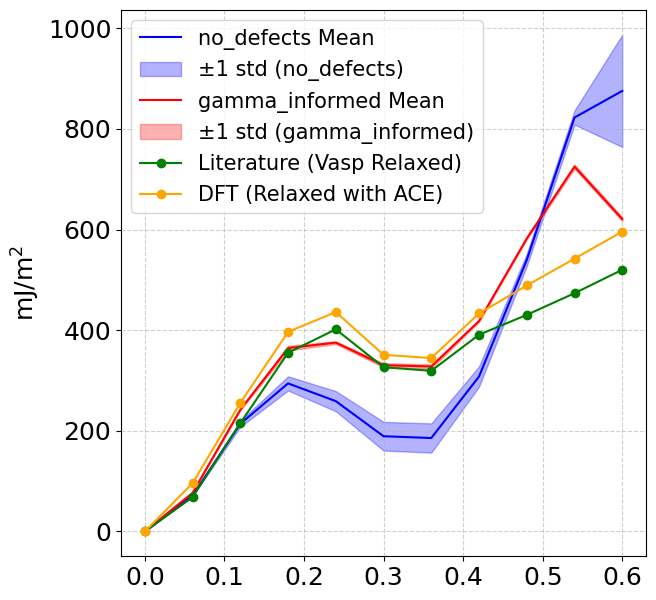

In [ ]:


supercell_basal = read("0_0_0_1.cfg",format='cfg')
supercell_basal = supercell_basal *(1,1,20)
slip_vec = np.array([-4.4085,2.54524866,0])

mean_e_g ,std_e_g ,mean_e_n ,std_e_n ,qm_mine , qm_lit = create_gamma_line(supercell_basal,slip_vec,"gamma_line_basal.xyz",calculator,0)


In [34]:
#    Here we look at the mean and std of the minima of all the graphs, which would be the stable stacking fault energy

#    As can be seen, the minima are all at the 7th point on the curve, which resembles the stable stacking fault energy.

#    Below are the minimal stacking fault energies, predicted by our committee of models, with the mean, and standard
#    deviation provided, and compared to our own DFT calculation of this energy, and literature DFT calculation also.

print(f"Our mean for the non-defect models is {mean_e_n[6]:.3f} with a standard deviation of {std_e_n[6]:.3f}")
print(f"Our mean for the gamma surface informed models is {mean_e_g[6]:.3f} with a standard deviation of {std_e_g[6]:.3f}")
print(f"Our mean DFT energy was {qm_mine[6]:.3f} whereas the literature was {qm_lit[6]:.3f}")
print()
print("Our DFT calculation was relaxed with the gamma surface informed model, ")
print("and then a single point energy was calculated, ")
print("so this will be above the real stable stacking fault energy predicted by our DFT. ")
print("This was done to avoid expensive geometry relaxations")





Our mean for the non-defect models is 185.732 with a standard deviation of 29.077
Our mean for the gamma surface informed models is 327.890 with a standard deviation of 4.197
Our mean DFT energy was 344.683 whereas the literature was 319.283

Our DFT calculation was relaxed with the gamma surface informed model, 
and then a single point energy was calculated, 
so this will be above the real stable stacking fault energy predicted by our DFT. 
This was done to avoid expensive geometry relaxations
